# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-7, 5e-7, 5e-6]
regularization_strengths = [2.5e4, 5e4, 1e6, 7e4, 1e5]

results = {}
best_val = -1
best_svm = None

#pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for l in learning_rates:
    for r in regularization_strengths:
        print(l, r)
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=l, reg=r,
                              num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        results[(l, r)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm    
#pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

1e-07 25000.0
1e-07 50000.0
1e-07 1000000.0
1e-07 70000.0
1e-07 100000.0
5e-07 25000.0
5e-07 50000.0
5e-07 1000000.0
5e-07 70000.0
5e-07 100000.0
5e-06 25000.0
5e-06 50000.0
5e-06 1000000.0


d:\_python\Python projects\cs231n\assignment1\cs231n\classifiers\linear_svm.py:78: RuntimeWarning: overflow encountered in double_scalars
  loss = np.sum(np.sum(loss_max, axis=1) - 1) / X.shape[0] + 0.5 * reg * np.sum(W * W)
d:\_python\Python projects\cs231n\assignment1\cs231n\classifiers\linear_svm.py:78: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(np.sum(loss_max, axis=1) - 1) / X.shape[0] + 0.5 * reg * np.sum(W * W)
d:\_python\Python projects\cs231n\assignment1\cs231n\classifiers\linear_svm.py:99: RuntimeWarning: overflow encountered in multiply
  dW += reg * W
d:\_python\Python projects\cs231n\assignment1\cs231n\classifiers\linear_svm.py:76: RuntimeWarning: invalid value encountered in subtract
  loss_diff = X.dot(W) - X.dot(W)[range(X.shape[0]), y].reshape(-1, 1) + 1
d:\_python\Python projects\cs231n\assignment1\cs231n\classifiers\linear_svm.py:77: RuntimeWarning: invalid value encountered in maximum
  loss_max = np.maximum(0, loss_diff)
d:\_python\Python proj

5e-06 70000.0
5e-06 100000.0
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.256082 val accuracy: 0.256000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.414531 val accuracy: 0.425000
lr 1.000000e-07 reg 7.000000e+04 train accuracy: 0.414245 val accuracy: 0.415000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.411122 val accuracy: 0.418000
lr 1.000000e-07 reg 1.000000e+06 train accuracy: 0.398816 val accuracy: 0.387000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.414714 val accuracy: 0.432000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.421673 val accuracy: 0.428000
lr 5.000000e-07 reg 7.000000e+04 train accuracy: 0.410714 val accuracy: 0.418000
lr 5.000000e-07 reg 1.000000e+05 train accuracy: 0.410245 val accuracy: 0.404000
lr 5.000000e-07 reg 1.000000e+06 train accuracy: 0.359041 val accuracy: 0.359000
lr 5.000000e-06 reg 2.500000e+04 train accuracy: 0.406755 val accuracy: 0.401000
lr 5.000000e-06 reg 5.000000e+04 train accuracy: 0.399776 val accuracy: 0.405000

In [6]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.418


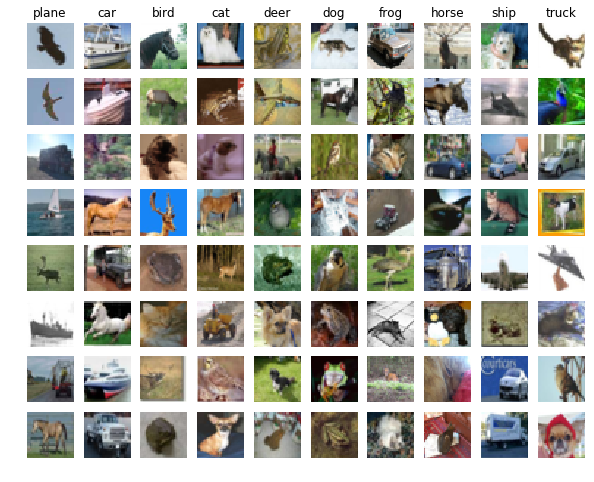

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [28]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]

num_classes = 10


best_net = None

results = {}
best_val = -1
learning_rates = [0.2, 0.25, 0.3]
regularization_strengths = [0.001, 0.0001]
hidden_size = [324, 400, 484, 512]
epochs = [2500, 3000]
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_params = 0
for l in learning_rates:
    for r in regularization_strengths:
        for h in hidden_size:
            for e in epochs:
                print('learning rate: {0}, regularization strength: {1}, hidden size: {2}, iterations: {3}'.format(l, r, h, e))
                net = TwoLayerNet(input_dim, h, num_classes)
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                    num_iters=e, batch_size=200,
                    learning_rate=l, learning_rate_decay=0.95,
                    reg=r, verbose=False)
                y_train_pred = net.predict(X_train_feats)
                train_acc = np.mean(y_train == y_train_pred)

                val_acc = (net.predict(X_val_feats) == y_val).mean()
                print('Validation accuracy: ', val_acc)
                results[(l, r, h, e)] = val_acc
                if val_acc > best_val:
                    best_val = val_acc
                    best_net = net   
                    best_params = (l, r, h, e)
#pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

learning rate: 0.2, regularization strength: 0.001, hidden size: 324, iterations: 2500
Validation accuracy:  0.59
learning rate: 0.2, regularization strength: 0.001, hidden size: 324, iterations: 3000
Validation accuracy:  0.602
learning rate: 0.2, regularization strength: 0.001, hidden size: 400, iterations: 2500
Validation accuracy:  0.594
learning rate: 0.2, regularization strength: 0.001, hidden size: 400, iterations: 3000
Validation accuracy:  0.6
learning rate: 0.2, regularization strength: 0.001, hidden size: 484, iterations: 2500
Validation accuracy:  0.592
learning rate: 0.2, regularization strength: 0.001, hidden size: 484, iterations: 3000
Validation accuracy:  0.59
learning rate: 0.2, regularization strength: 0.001, hidden size: 512, iterations: 2500
Validation accuracy:  0.595
learning rate: 0.2, regularization strength: 0.001, hidden size: 512, iterations: 3000
Validation accuracy:  0.597
learning rate: 0.2, regularization strength: 0.0001, hidden size: 324, iterations: 2

In [29]:
best_params

(0.3, 0.001, 512, 2500)

In [27]:
best_params1

(0.2, 0.0001, 324, 2500)

In [30]:
best_net_ = TwoLayerNet(input_size, best_params[2], num_classes)
stats = best_net_.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=best_params[3], batch_size=200,
            learning_rate=best_params[0], learning_rate_decay=0.95,
            reg=best_params[1], verbose=True)

iteration 0 / 2500: loss 2.302585
iteration 100 / 2500: loss 1.741805
iteration 200 / 2500: loss 1.490693
iteration 300 / 2500: loss 1.461216
iteration 400 / 2500: loss 1.360127
iteration 500 / 2500: loss 1.353104
iteration 600 / 2500: loss 1.317184
iteration 700 / 2500: loss 1.291894
iteration 800 / 2500: loss 1.188854
iteration 900 / 2500: loss 1.162487
iteration 1000 / 2500: loss 1.342321
iteration 1100 / 2500: loss 1.171630
iteration 1200 / 2500: loss 1.132961
iteration 1300 / 2500: loss 1.190395
iteration 1400 / 2500: loss 1.154563
iteration 1500 / 2500: loss 1.076150
iteration 1600 / 2500: loss 1.126466
iteration 1700 / 2500: loss 1.175450
iteration 1800 / 2500: loss 1.017278
iteration 1900 / 2500: loss 1.027738
iteration 2000 / 2500: loss 1.135656
iteration 2100 / 2500: loss 0.996859
iteration 2200 / 2500: loss 0.958953
iteration 2300 / 2500: loss 0.980922
iteration 2400 / 2500: loss 0.945573


In [31]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net_.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.594


In [32]:
best_net_ = TwoLayerNet(input_size, best_params[2], num_classes)
stats = best_net_.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=5000, batch_size=200,
            learning_rate=best_params[0], learning_rate_decay=0.95,
            reg=best_params[1], verbose=True)

test_acc = (best_net_.predict(X_test_feats) == y_test).mean()
print(test_acc)

iteration 0 / 5000: loss 2.302585
iteration 100 / 5000: loss 1.870888
iteration 200 / 5000: loss 1.475874
iteration 300 / 5000: loss 1.297665
iteration 400 / 5000: loss 1.264724
iteration 500 / 5000: loss 1.352614
iteration 600 / 5000: loss 1.218169
iteration 700 / 5000: loss 1.194417
iteration 800 / 5000: loss 1.450043
iteration 900 / 5000: loss 1.357454
iteration 1000 / 5000: loss 1.262519
iteration 1100 / 5000: loss 1.307974
iteration 1200 / 5000: loss 1.254074
iteration 1300 / 5000: loss 1.141959
iteration 1400 / 5000: loss 1.235261
iteration 1500 / 5000: loss 1.264003
iteration 1600 / 5000: loss 1.147107
iteration 1700 / 5000: loss 1.216416
iteration 1800 / 5000: loss 0.993320
iteration 1900 / 5000: loss 1.073805
iteration 2000 / 5000: loss 1.071984
iteration 2100 / 5000: loss 1.090805
iteration 2200 / 5000: loss 0.941354
iteration 2300 / 5000: loss 1.003568
iteration 2400 / 5000: loss 0.990245
iteration 2500 / 5000: loss 1.070841
iteration 2600 / 5000: loss 1.007301
iteration 270

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!